### Import necessary modules

In [1]:
import numpy as np
import torch

### Download the dataset

In [5]:
from torchvision import datasets, transforms

batch_size = 32

transform = transforms.ToTensor()

train_data = datasets.MNIST('~/.pytorch/MNIST_data', train=True, transform=transform, download=True)
test_data = datasets.MNIST('~/.pytorch/MNIST_data', train=False, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Visualize the data

In [37]:
images, labels = next(iter(trainloader))

img = images[0]
print(img.shape)

img = img.squeeze()
print(img.shape)

torch.Size([1, 28, 28])
torch.Size([28, 28])


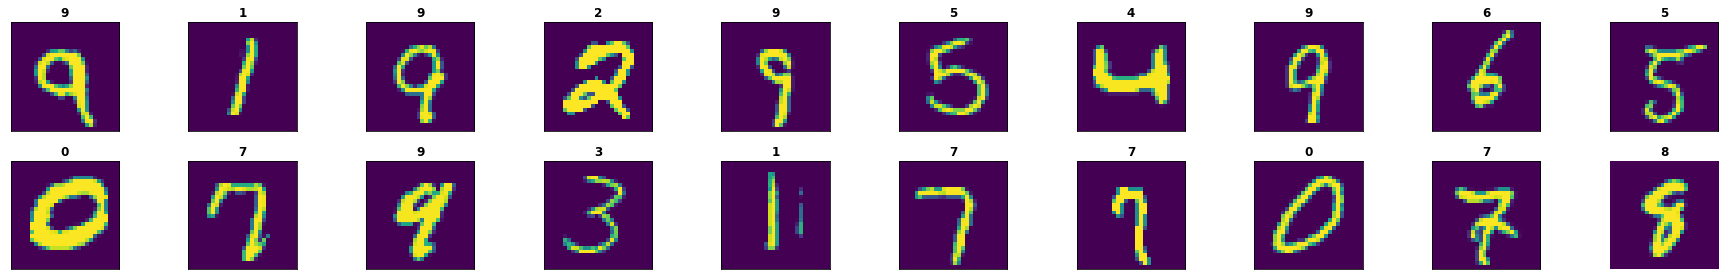

In [34]:
import matplotlib.pyplot as plt

# Take some sample images
images, labels = next(iter(trainloader))

fig, axes = plt.subplots(images[0].shape[1]//10, 10, figsize=(25, 4)) # print 10 images per row

for i, (img, label) in enumerate(zip(images[:20], labels[:20])):
    img = img.numpy().squeeze()
    
    ax = axes[i//10, i%10]
    ax.imshow(img)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(label.item())
    
fig.tight_layout()
plt.axis('off');

### Visualize an image in more detail

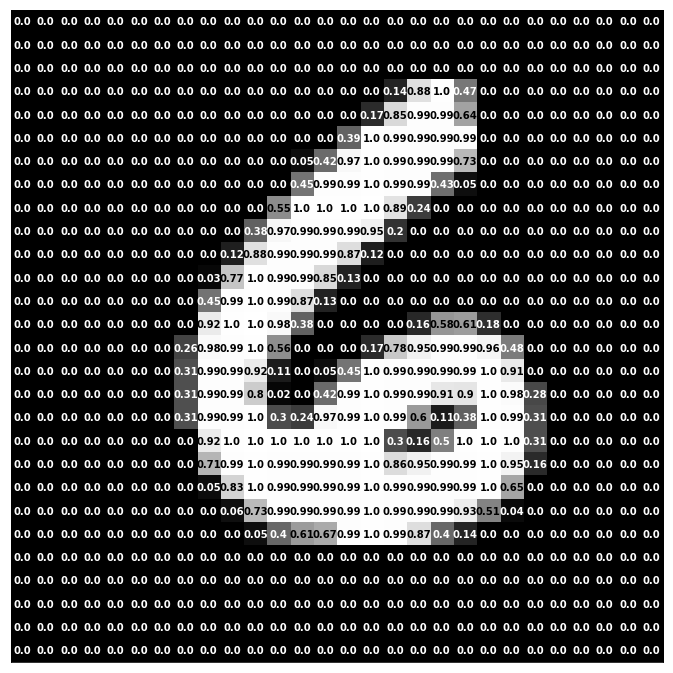

In [54]:
img = images[0]
img = img.numpy().squeeze()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.imshow(img, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

width, height = img.shape[0], img.shape[1]
threshold = img.max()/ 2

for i in range(width):
    for j in range(height):
        text = img[i, j].round(2)
        ax.annotate(text, (j, i),
                   color='black' if text > threshold else 'white',
                   horizontalalignment='center',
                   verticalalignment='center')

### Build the NN

In [64]:
from collections import OrderedDict

from torch import nn
from torch.nn import functional as F

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # first hidden layer - fully connected to the input layer
        self.fc1 = nn.Linear(784, 512)
        # second hidden layer
        self.fc2 = nn.Linear(512, 512)
        # output layer - outputs 10 values
        self.output = nn.Linear(512, 10)
        
    def forward(self, x):
        # flatten image input
        x = x.view(x.shape[0], -1)
        
        # define NN layers
        # layer 1 with relu activation and dropout
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        # layer 2 with relu activation and dropout
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        # output layer with log-softmax activation
        x = F.log_softmax(self.output(x), dim=1)
        
        return x
    
model = NN()

### Identify loss and optimizer to use

In [69]:
from torch import optim

# loss function
criterion = nn.NLLLoss() # because we output log-softmax
# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.05)

### Train the model

In [68]:
# no.of rounds of training
n_epochs = 30

training_loss = 0

for epoch in range(n_epochs):
    model.train()
    for images, labels in trainloader:
        optimizer.zero_grad()

        logps = model(images)   #  1. Forward prop
        loss = criterion(logps, labels) #  2. Calculate loss
        loss.backward()         #  3. Backpropogate to populate gradients
        optimizer.step()        #  4. Model parameter update step

        training_loss += loss.item() * images.shape[0]
    else:    
        training_loss /= len(trainloader)
    
    print(f'Epoch: {epoch+1} \tTraining Loss: {training_loss:.6f}')

Epoch: 1 	Training Loss: 5.897114
Epoch: 2 	Training Loss: 4.068557
Epoch: 3 	Training Loss: 3.172313
Epoch: 4 	Training Loss: 2.525348
Epoch: 5 	Training Loss: 2.179801
Epoch: 6 	Training Loss: 1.864708
Epoch: 7 	Training Loss: 1.625192
Epoch: 8 	Training Loss: 1.400989
Epoch: 9 	Training Loss: 1.202679
Epoch: 10 	Training Loss: 1.111407
Epoch: 11 	Training Loss: 0.980282
Epoch: 12 	Training Loss: 0.847304
Epoch: 13 	Training Loss: 0.782811
Epoch: 14 	Training Loss: 0.702057
Epoch: 15 	Training Loss: 0.629554
Epoch: 16 	Training Loss: 0.591401
Epoch: 17 	Training Loss: 0.514488
Epoch: 18 	Training Loss: 0.486838
Epoch: 19 	Training Loss: 0.436509
Epoch: 20 	Training Loss: 0.400683
Epoch: 21 	Training Loss: 0.390414
Epoch: 22 	Training Loss: 0.351969
Epoch: 23 	Training Loss: 0.329928
Epoch: 24 	Training Loss: 0.289145
Epoch: 25 	Training Loss: 0.282843
Epoch: 26 	Training Loss: 0.266076
Epoch: 27 	Training Loss: 0.267392
Epoch: 28 	Training Loss: 0.247797
Epoch: 29 	Training Loss: 0.2

### Test the network

In [ ]:
val_loss = 0
accuracy = 0

class_correct = [0]*10
class_total = [0]*10

with torch.no_grad():
    model.eval()

    for images, labels in testloader:

        logps = model(images)               # 1. Forward prop - calculate output
        loss = criterion(logps, labels)     # 2. Calculate Loss

        val_loss += loss.item() * images.shape[0]

        ps = np.exp(logps)
        top_ps, top_classes = ps.topk(1, dim=1)
        equals = top_classes == labels.view(*top_classes.shape)

        for i in range(len(labels)):
          class_total[labels[i]] += 1
          class_correct[labels[i]] += equals[i].item()

        accuracy += torch.mean(equals.type(torch.FloatTensor))

    else:
        accuracy /= len(testloader)
        val_loss /= len(testloader)

        print('Test Loss: {:.6f}\n'.format(val_loss))

        for i in range(10):
          correct, total = class_correct[i], class_total[i]
          print(f"Test accuracy of class:{i} - {correct/total:.3f}% ({correct}/{total})")

        print(f'Test accuracy: {accuracy:.3f} ({sum(class_correct)}/{sum(class_total)})\n')

In [ ]:
labels

In [ ]:
top_classes.view(1, -1)

In [ ]:
equals.view_as(labels)

In [ ]:
class_correct = [0]*10
class_total = [0]*10

In [ ]:
for i in range(len(labels)):
  class_total[labels[i]] += 1
  class_correct[labels[i]] += equals[i]

In [ ]:
print(sum(class_total))
print(sum(class_correct))

### Visualize

In [2]:
images, labels = next(iter(testloader))

logps = model(images)
ps = torch.exp(logps)

top_ps, top_classes = ps.topk(1, dim=1)

fig, axes = plt.subplots(2, 10, figsize=(25, 4))
for i in range(20):
  img = images[i].numpy().squeeze()
  
  ax = axes[i//10, i%10]
  ax.imshow(img)
  
  ax.set_xticks([])
  ax.set_yticks([])
  
  actual = labels[i] 
  pred = top_classes[i]
  
  ax.set_title(title, color=("green" if actual==pred else "red"))

NameError: name 'testloader' is not defined

In [ ]:
f'{labels[i]}({top_classes[i].item()})'